<h2>DAT 402</h2>
<h2> Project 2</h2>
<h2>Joshua Gold</h2>

<H4>Detecting fraudulent credit card transactions with the use of neural nets and random forest classification algorithms.</H4>
Can neural nets or random forest classification be used to detect fraudulent credit card transactions accurately, and if so which of the two methods have better performance.

<h3>Imports and Libraries</h3>

In [197]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import keras.models
import keras.layers
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

<H3>Loading in dataset</H3>

In [198]:
# set 1
fraud_test = pd.read_csv('fraudTest.csv')
# set 2
fraud_train = pd.read_csv('fraudTrain.csv')
# combine
df = pd.concat([fraud_test,fraud_test]).reset_index()
# preview
df.head()

,index,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


<h3>Data Cleanup</h3>

In [199]:
df.drop(['Unnamed: 0','first','last','index','unix_time'],axis=1,inplace=True)
df.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,44.959148,-85.884734,0


<h2>Exploring Data</h2>

<H3> Calculate Distance between two latitude and longitude points</h3>


In [200]:
# return distance in kilometers between two points
def distance(lat1,lon1,lat2,lon2):
    latr1 = math.radians(lat1)
    lonr1 = math.radians(lon1)
    lat2r = math.radians(lat2)
    lon2r = math.radians(lon2)
    distance = 6371 * math.acos(math.sin(latr1)*math.sin(lat2r) + math.cos(latr1) * math.cos(lat2r) * math.cos(lonr1-lon2r))
    return distance

<h3>Calculating Distance of Purchase</h3>

In [201]:
purchase_distance_list = []

# calc distance
for index, row in df.iterrows():
    lat1 = row['lat']
    lon1 = row['long']
    lat2 = row['merch_lat']
    lon2 = row['merch_long']
    purchase_distance = distance(lat1,lon1,lat2,lon2)
    purchase_distance_list.append(purchase_distance)

# adding column to dataset
df['purchase_distance'] = purchase_distance_list
display(df)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,purchase_distance
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,33.986391,-81.200714,0,24.561462
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,39.450498,-109.960431,0,104.925092
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,40.495810,-74.196111,0,59.080078
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,28.812398,-80.883061,0,27.698567
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,44.959148,-85.884734,0,104.335106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111433,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,M,558 Michael Estates,Luray,MO,63453,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,39.946837,-91.333331,0,77.026148
1111434,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,M,572 Davis Mountains,Lake Jackson,TX,77566,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,29.661049,-96.186633,0,100.074420
1111435,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,46.658340,-119.715054,0,80.759302
1111436,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,44.470525,-117.080888,0,52.933240


<h4>Average Purchase Distance By State</h4>

In [202]:
print('Average Distance of Purchase (overall):', np.mean(df['purchase_distance']))
state_list = df['state'].unique()

avg_state_purchase_distance = []
for x in state_list:
    df_temp = df[df['state'] == x]
    avg_distance = np.mean(df_temp['purchase_distance'])
    avg_state_purchase_distance.append(avg_distance)
    

Average Distance of Purchase (overall): 76.10490213840868


<h3>Average Purchase Amount by Job</h3>

In [203]:
by_job_data = df.copy()
avg_purchase_by_job = by_job_data.groupby('job')['amt'].mean().reset_index()
avg_purchase_by_job.columns = ['job','avg_amt_by_job']
by_job_data = by_job_data.merge(avg_purchase_by_job,on='job')
df = df.merge(avg_purchase_by_job,on='job')

display(by_job_data)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,...,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,purchase_distance,avg_amt_by_job
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,M,351 Darlene Green,Columbia,SC,29209,...,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,33.986391,-81.200714,0,24.561462,64.120992
1,2020-06-21 14:24:30,639030014711,fraud_Rau-Grant,kids_pets,55.30,M,696 Matthew Ford Suite 157,Olmsted,IL,62970,...,-89.0933,639,Mechanical engineer,1982-08-01,72de7662f124557e514c1b5f68dcbcfd,36.868586,-89.428053,0,46.779090,64.120992
2,2020-06-21 15:23:25,213124978348176,fraud_Schuppe LLC,entertainment,7.73,M,079 Chelsea Rest,Belfast,NY,14711,...,-78.0943,1766,Mechanical engineer,1962-06-04,047a16d34637d7c6104da4751f7842c9,43.055911,-78.506100,0,88.481090,64.120992
3,2020-06-21 15:35:18,2248348993063230,fraud_Schuppe-Schuppe,food_dining,4.66,F,376 John Fork Suite 848,Randolph,OH,44265,...,-81.2977,51,Mechanical engineer,1960-08-05,5991327c4631fef4e8d4754be562cc2c,41.700131,-81.791089,0,87.001944,64.120992
4,2020-06-21 15:39:04,2291163933867244,fraud_Goyette-Gerhold,kids_pets,17.15,M,351 Darlene Green,Columbia,SC,29209,...,-80.9355,333497,Mechanical engineer,1968-03-19,2ba65201d0c9119227e27b6640ff4415,34.235448,-81.649282,0,72.233332,64.120992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111433,2020-09-04 23:26:00,3550412175018089,fraud_Welch Inc,misc_net,677.77,F,742 Sellers Ferry,Lexington,KY,40502,...,-84.4854,296965,Software engineer,1962-12-30,d6d0a2a41f87898f6fcdd0567938ca28,37.650845,-84.899474,1,54.622739,726.183636
1111434,2020-09-04 23:54:40,3550412175018089,"fraud_Mosciski, Ziemann and Farrell",shopping_net,1113.85,F,742 Sellers Ferry,Lexington,KY,40502,...,-84.4854,296965,Software engineer,1962-12-30,388d8fa9368497e8f2943600d6276279,38.913846,-83.831596,1,114.787278,726.183636
1111435,2020-09-05 03:05:14,3550412175018089,fraud_Koepp-Parker,grocery_pos,244.56,F,742 Sellers Ferry,Lexington,KY,40502,...,-84.4854,296965,Software engineer,1962-12-30,5a02adb898b82b9ba7db627f5b6ea343,37.367520,-84.737439,1,75.589564,726.183636
1111436,2020-09-05 23:38:04,3550412175018089,"fraud_Reichert, Rowe and Mraz",shopping_net,881.37,F,742 Sellers Ferry,Lexington,KY,40502,...,-84.4854,296965,Software engineer,1962-12-30,9e5bf05c064277c5795ca45b601d7b33,38.222233,-84.171104,1,35.703014,726.183636


<h3>Converting Datetime to time to day, hour, month and year</h3>

In [204]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_day'] = df['trans_date_trans_time'].dt.day_name()
df['trans_month'] = df['trans_date_trans_time'].dt.month_name()
df['trans_year'] = df['trans_date_trans_time'].dt.year
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,...,trans_num,merch_lat,merch_long,is_fraud,purchase_distance,avg_amt_by_job,trans_hour,trans_day,trans_month,trans_year
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,M,351 Darlene Green,Columbia,SC,29209,...,2da90c7d74bd46a0caf3777415b3ebd3,33.986391,-81.200714,0,24.561462,64.120992,12,Sunday,June,2020
1,2020-06-21 14:24:30,639030014711,fraud_Rau-Grant,kids_pets,55.30,M,696 Matthew Ford Suite 157,Olmsted,IL,62970,...,72de7662f124557e514c1b5f68dcbcfd,36.868586,-89.428053,0,46.779090,64.120992,14,Sunday,June,2020
2,2020-06-21 15:23:25,213124978348176,fraud_Schuppe LLC,entertainment,7.73,M,079 Chelsea Rest,Belfast,NY,14711,...,047a16d34637d7c6104da4751f7842c9,43.055911,-78.506100,0,88.481090,64.120992,15,Sunday,June,2020
3,2020-06-21 15:35:18,2248348993063230,fraud_Schuppe-Schuppe,food_dining,4.66,F,376 John Fork Suite 848,Randolph,OH,44265,...,5991327c4631fef4e8d4754be562cc2c,41.700131,-81.791089,0,87.001944,64.120992,15,Sunday,June,2020
4,2020-06-21 15:39:04,2291163933867244,fraud_Goyette-Gerhold,kids_pets,17.15,M,351 Darlene Green,Columbia,SC,29209,...,2ba65201d0c9119227e27b6640ff4415,34.235448,-81.649282,0,72.233332,64.120992,15,Sunday,June,2020


<h3>Finding percentage of fraudulent transactions by category</h3>

category
entertainment     0.147117
food_dining       0.137517
gas_transport     0.273195
grocery_net       0.211057
grocery_pos       0.922878
health_fitness    0.141790
home              0.127997
kids_pets         0.133492
misc_net          0.975628
misc_pos          0.208249
personal_care     0.177995
shopping_net      1.211135
shopping_pos      0.427788
travel            0.229239
Name: is_fraud, dtype: float64


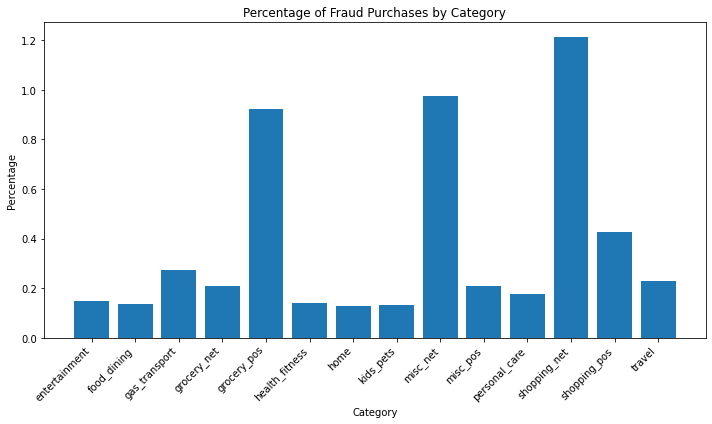

In [205]:
fraud_percentage_by_cat = df.groupby("category")["is_fraud"].mean()*100

# Calculate the percentage of fraud purchases by category
fraud_pct = df[df['is_fraud'] == 1].groupby('category')['is_fraud'].count() / df.groupby('category')['is_fraud'].count()
fraud_pct = fraud_pct.fillna(0) * 100
print(fraud_percentage_by_cat)

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(fraud_pct.index, fraud_pct.values)
ax.set_title('Percentage of Fraud Purchases by Category')
ax.set_xlabel('Category')
ax.set_ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<h3>Percentage of fraud vs hour</h3>

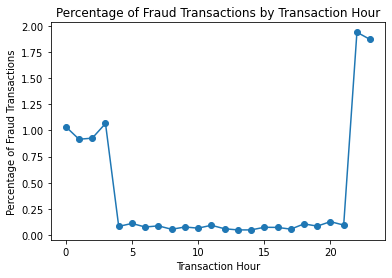

In [206]:
# Compute the percentage of fraud transactions by trans_hour
fraud_by_hour = df.groupby('trans_hour')['is_fraud'].mean() * 100

# Plot the results
plt.plot(fraud_by_hour.index, fraud_by_hour.values, marker='o')
plt.xlabel('Transaction Hour')
plt.ylabel('Percentage of Fraud Transactions')
plt.title('Percentage of Fraud Transactions by Transaction Hour')
plt.show()

<h3>Prepping Data for Analysis and Encoding non-numerical Data</h3>

In [207]:
#copy dataframe
data = df.copy()

cat_columns = ['merchant','category','gender','street','city','state','job','dob','trans_day','trans_month']
le = LabelEncoder()

# encode non-numerical 
for x in cat_columns:
    data[x] = le.fit_transform(data[x])

In [208]:
display(data.head())
print(data.columns)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,...,trans_num,merch_lat,merch_long,is_fraud,purchase_distance,avg_amt_by_job,trans_hour,trans_day,trans_month,trans_year
0,2020-06-21 12:14:25,2291163933867244,319,10,2.86,1,341,157,39,29209,...,2da90c7d74bd46a0caf3777415b3ebd3,33.986391,-81.200714,0,24.561462,64.120992,12,3,3,2020
1,2020-06-21 14:24:30,639030014711,495,7,55.30,1,654,570,13,62970,...,72de7662f124557e514c1b5f68dcbcfd,36.868586,-89.428053,0,46.779090,64.120992,14,3,3,2020
2,2020-06-21 15:23:25,213124978348176,574,0,7.73,1,68,58,33,14711,...,047a16d34637d7c6104da4751f7842c9,43.055911,-78.506100,0,88.481090,64.120992,15,3,3,2020
3,2020-06-21 15:35:18,2248348993063230,576,1,4.66,0,366,636,34,44265,...,5991327c4631fef4e8d4754be562cc2c,41.700131,-81.791089,0,87.001944,64.120992,15,3,3,2020
4,2020-06-21 15:39:04,2291163933867244,202,7,17.15,1,341,157,39,29209,...,2ba65201d0c9119227e27b6640ff4415,34.235448,-81.649282,0,72.233332,64.120992,15,3,3,2020


Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop',
       'job', 'dob', 'trans_num', 'merch_lat', 'merch_long', 'is_fraud',
       'purchase_distance', 'avg_amt_by_job', 'trans_hour', 'trans_day',
       'trans_month', 'trans_year'],
      dtype='object')


In [209]:
# Convert the datetime column to Unix timestamp
data = data.drop('trans_date_trans_time',axis=1)

# drop irrelevant data 
data = data.drop('trans_num',axis=1)


<h3>Shuffle and Preview Encoded Dataset</h3>

In [210]:
data = data.sample(frac=1)
display(data)

,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,...,dob,merch_lat,merch_long,is_fraud,purchase_distance,avg_amt_by_job,trans_hour,trans_day,trans_month,trans_year
384938,630424987505,459,4,90.34,0,274,757,48,26292,39.1505,...,607,38.720922,-79.341446,0,49.768735,62.958325,3,3,5,2020
247009,4319584480204988982,569,1,19.01,0,8,173,16,41810,37.1788,...,241,36.422255,-83.369113,0,103.340112,75.311770,22,3,0,2020
361456,6011492816282597,238,11,39.67,1,290,714,2,71762,33.3398,...,694,32.495647,-93.434082,0,113.830290,64.259377,12,5,2,2020
1690,639030014711,102,5,75.83,1,654,570,13,62970,37.1935,...,623,38.098657,-88.365252,0,119.326353,64.120992,13,4,4,2020
635592,30263540414123,679,6,15.48,1,145,313,43,84735,37.7175,...,265,37.803802,-113.456371,0,86.566156,59.323895,15,1,3,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738241,4613314721966,265,9,38.15,1,513,154,26,28611,35.9946,...,741,35.533808,-82.506450,0,87.041455,76.781119,8,3,5,2020
177713,4116554952971686,577,10,36.04,0,468,619,8,34953,27.2625,...,34,27.187605,-81.185271,0,80.125291,58.583080,18,5,0,2020
562355,3582754887089201,187,6,87.92,1,410,542,2,71960,34.4596,...,343,34.718117,-93.319314,0,43.385326,62.928368,15,6,4,2020
138013,4223708906367574214,156,9,37.72,1,262,514,34,45051,39.0965,...,492,39.184228,-84.837073,0,19.365205,65.714582,1,6,4,2020


<h3>Data Splitting and Constructing The Neural Net</h3>

In [211]:
# x and y for neural net
X = data.drop(columns=['is_fraud'])
y = data['is_fraud']

# split the dataset for testing and training
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# normalize the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#Instantiate nerual net model
model = keras.models.Sequential()

#input layer
model.add(keras.layers.Dense(256,input_dim=X_train.shape[1],activation='relu'))

#hidden layers
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))

# Add output layer
model.add(keras.layers.Dense(1, activation='sigmoid'))

<h3>Compile and Training Nerual Net</h3>

In [212]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
27786/27786 [==============================] - 34s 1ms/step - loss: 0.0135 - accuracy: 0.9972 - val_loss: 0.0116 - val_accuracy: 0.9977
Epoch 2/20
27786/27786 [==============================] - 32s 1ms/step - loss: 0.0091 - accuracy: 0.9980 - val_loss: 0.0084 - val_accuracy: 0.9979
Epoch 3/20
27786/27786 [==============================] - 32s 1ms/step - loss: 0.0077 - accuracy: 0.9982 - val_loss: 0.0094 - val_accuracy: 0.9982
Epoch 4/20
27786/27786 [==============================] - 32s 1ms/step - loss: 0.0070 - accuracy: 0.9984 - val_loss: 0.0092 - val_accuracy: 0.9982
Epoch 5/20
27786/27786 [==============================] - 32s 1ms/step - loss: 0.0065 - accuracy: 0.9985 - val_loss: 0.0079 - val_accuracy: 0.9983
Epoch 6/20
27786/27786 [==============================] - 32s 1ms/step - loss: 0.0060 - accuracy: 0.9986 - val_loss: 0.0068 - val_accuracy: 0.9984
Epoch 7/20
27786/27786 [==============================] - 32s 1ms/step - loss: 0.0060 - accuracy: 0.9986 - val_loss: 0

In [213]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

6947/6947 [==============================] - 4s 596us/step
[[221328     93]
 [   216    651]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    221421
           1       0.88      0.75      0.81       867

    accuracy                           1.00    222288
   macro avg       0.94      0.88      0.90    222288
weighted avg       1.00      1.00      1.00    222288



<h4>Nerual Net model accuracy, precision, recall and F1 score</h4>

In [214]:
# Predict on the testing data
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary labels
y_pred = (y_pred > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

nn_accuracy = accuracy
nn_precision = precision
nn_recall = recall
nn_f1 = f1

6947/6947 [==============================] - 4s 613us/step
Accuracy: 0.998609911466206
Precision: 0.875
Recall: 0.7508650519031141
F1 Score: 0.8081936685288641


<h4>Model accuracy and validation loss over epoch</h4>

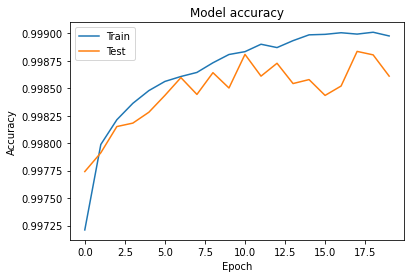

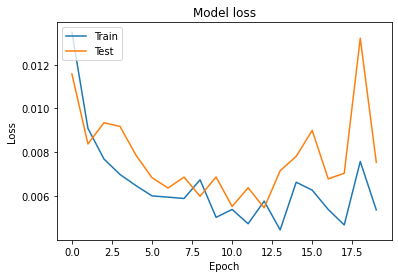

In [215]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


<h4>Confusion Matrix</h4>

6947/6947 [==============================] - 4s 610us/step


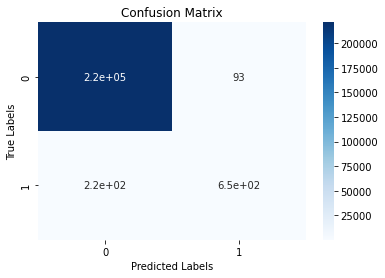

In [216]:
# Get predictions on test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<h3>ROC Curve of Neural Net</h3>

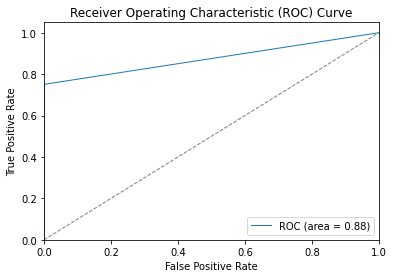

In [217]:
# Get ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

<h3>Random Forest Model</h3>

In [218]:
X_train,X_test,y_train,y_test = train_test_split(data.drop('is_fraud',axis=1),data['is_fraud'],test_size=0.2,random_state=42)

# random forest model
rf = RandomForestClassifier(n_estimators=100,random_state=42)

rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

# evaluate the models Accuracy, precision, recall and F1 Score
print("Model Evaluation")
print("------------")
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

rf_1_acc = accuracy_score(y_test,y_pred)
rf_1_pr = precision_score(y_test, y_pred)
rf_1_re = recall_score(y_test,y_pred)
rf_1_f1 = f1_score(y_test,y_pred)

Model Evaluation
------------
Accuracy: 0.9996221118548909
Precision: 0.9974587039390089
Recall: 0.9054209919261822
F1 score: 0.9492140266021765


<h3>Feature Importance</h3>

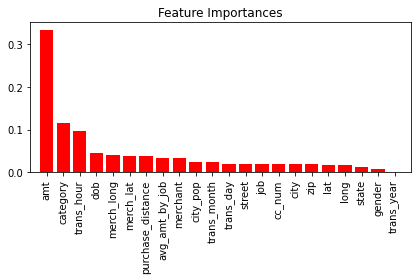

In [219]:
# calculate feature importanct
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# make chart of features vs importance (0-1)
plt.figure()
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], color='r', align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

In [220]:
tuned_data = data.copy()
tuned_data=tuned_data.drop(['trans_year'],axis=1)

<H3>Tuned Model</h3>

In [221]:
X_train,X_test,y_train,y_test = train_test_split(tuned_data.drop('is_fraud',axis=1),tuned_data['is_fraud'],test_size=0.2,random_state=42)


rf_t = RandomForestClassifier(n_estimators=100,random_state=42)

rf_t.fit(X_train,y_train)
y_pred = rf_t.predict(X_test)

# saving model 2s scores for comparison 
rf_2_acc = accuracy_score(y_test,y_pred)
rf_2_pr = precision_score(y_test, y_pred)
rf_2_re = recall_score(y_test,y_pred)
rf_2_f1 = f1_score(y_test,y_pred)

<h3>Random Forest Model Evaluation</h3>

In [222]:
# Accuracy, Precision, Recall, F1 score

# evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

print('----------------------------')
print("Accuracy gain:", rf_2_acc-rf_1_acc)
print("Precision gain:", rf_2_pr-rf_1_pr)
print("Recall gain:", rf_2_re-rf_1_re)
print("F1 gain:", rf_2_f1-rf_1_f1)

Accuracy: 0.9996131145181026
Precision: 0.9974522292993631
Recall: 0.903114186851211
F1 score: 0.9479418886198548
----------------------------
Accuracy gain: -8.997336788274524e-06
Precision gain: -6.4746396458703614e-06
Recall gain: -0.0023068050749711633
F1 gain: -0.0012721379823216195


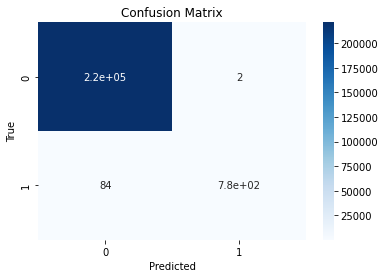

In [223]:
y_pred = rf_t.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

<h3>Random Forest ROC Curve</h3>

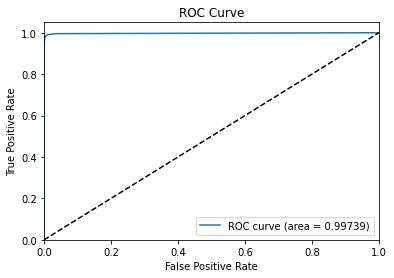

In [224]:
y_pred_prob = rf_t.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

<h3>Comparaison</h3>
The credit card transaction dataset was run through two different types of models, neural net and random forest.

NN accuracy: 0.998609911466206
RF accuracy 0.9996131145181026
NN precision: 0.875
RF precision: 0.9974522292993631
NN recall: 0.7508650519031141
RF recall 0.903114186851211
NN F1 score: 0.8081936685288641
RF F1 score: 0.9479418886198548


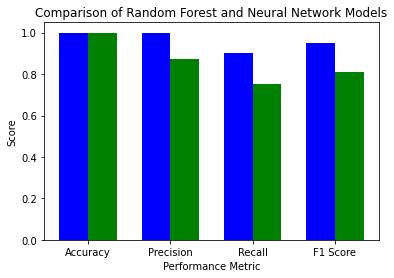

In [225]:
# NN Performance vs Random Forest
print("NN accuracy:",nn_accuracy)
print("RF accuracy", rf_2_acc)
print("NN precision:",nn_precision)
print("RF precision:",rf_2_pr)
print("NN recall:",nn_recall)
print("RF recall",rf_2_re)
print("NN F1 score:",nn_f1)
print("RF F1 score:",rf_2_f1)

# Performance metrics for Random Forest and Neural Network models
rf_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
rf_scores = [rf_2_acc, rf_2_pr, rf_2_re, rf_2_f1] # Replace with actual scores from your model

nn_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
nn_scores = [nn_accuracy, nn_precision, nn_recall, nn_f1] # Replace with actual scores from your model

# Set the bar width
bar_width = 0.35

# Set the x-axis positions
rf_x_pos = np.arange(len(rf_metrics))
nn_x_pos = [x + bar_width for x in rf_x_pos]

# Create the bar plot
plt.bar(rf_x_pos, rf_scores, width=bar_width, color='blue', label='Random Forest')
plt.bar(nn_x_pos, nn_scores, width=bar_width, color='green', label='Neural Network')

# Set the axis labels and title
plt.xlabel('Performance Metric')
plt.ylabel('Score')
plt.title('Comparison of Random Forest and Neural Network Models')

# Set the axis tick positions and labels
plt.xticks([x + bar_width/2 for x in rf_x_pos], rf_metrics)

# Show the plot
plt.show()

Blue: Random Forest <br>
Green: Neural Net

<h3>Results</h3>

The random forest model had a higher F1 score than the neural net as well as a higher precision and recall score. In this case random forest had an overall higher performance. Although in this short test the random forest score was much higher this does not mean that a neural net with additional tuning would not outperform a random forest model. 

<h4>Sources</h4>
<p>Dataset <br>
<a>https://www.kaggle.com/datasets/kartik2112/fraud-detection?select=fraudTest.csv<a>
</p>